# Safety

## Decide if $(d, cap)$ is safe in a given state
Given a state $s$ we want to decide whether there exists a strategy $\sigma$ such that all runs that follow $\sigma$ and that start with the initial resource value $d$ in $s$ will be safe in a system with capacity $cap$. By safe here we mean that the resource will never be depleted.

### MinInitCons
The function $\mathrm{MinInitCons}[\mathcal{M}]: S \to \mathbb{N} \cup \{\infty\}$ computes the minimal consumption until a reload state is reached.

In [14]:
%%writefile safety.py
from math import inf
import sys

class minInitCons:
    """Compute function minInitCons for given consMDP `m`.

    minInitCons_m: S -> N ∪ {∞} returns for given `s` the minimum
    amount `s_m` of resource such that there exists a strategy that
    guarantees reachability of some reload state from s consuming
    at most `s_m`.

    Typical use:
    MI = minInitCons(mdp)
    MI.get_values()
    """

    def __init__(self, mdp, cap = inf):
        self.mdp         = mdp
        self.states      = mdp.num_states
        self.values      = None
        self.safe_values = None
        self.cap         = cap

        self.is_reload  = lambda x: self.mdp.is_reload(x)

    def action_value(self, a, values, zero_cond = None):
        if zero_cond is None:
            zero_cond = self.is_reload
        non_reload_succs = [values[succ] for succ in a.distr.keys()
                   if not zero_cond(succ)]
        a_v = 0 if len(non_reload_succs) == 0 else max(non_reload_succs)
        return a_v + a.cons

    def fixpoint(self):
        """Computes the functional F for given capacity.

        The functionals compute for each state `s` the maximum
        energy needed to reach a reload state from `s`.
        """
        # initialization
        values = [inf for s in range(self.states)]
        self.values = values
        action_value = lambda a: self.action_value(a, values)

        # iterate until a fixpoint is reached (at most |S| iterations)
        iterate = True
        while iterate:
            iterate = False

            for s in range(self.states):
                current_v = values[s]
                actions = self.mdp.actions_for_state(s)
                # candidate_v is now the minimum over action values
                candidate_v = min([action_value(a) for a in actions])

                # F is monotonicly decreasing, # check for decrease only
                if candidate_v < current_v and candidate_v <= self.cap:
                    values[s] = candidate_v
                    iterate = True

        self.values = values

    def safe_reloads_fixpoint(self):
        """Iterate on minInitCons and disable reloads with MI > cap

        Basicaly a least fixpoint that starts with minInitCons. If some
        reload has MI > cap, it is converted to ∞, and we no longer treat
        it as a reload state.

        Currently, we perform at most |S| iterations.
        """
        if self.values is None:
            raise RuntimeError("safe_reloads_fixpoint can be called " +
                               "only after minInitCons aka fixpoint " +
                               "was called")

        # Initialization
        values = list(self.values)
        self.safe_values = values
        zero_c = lambda succ: (self.mdp.is_reload(succ) and \
                              values[succ] <= self.cap and \
                              values[succ] != inf)
        action_value = lambda a: self.action_value(a, values, zero_c)

        # iterate until a fixpoint is reached or for at most |S| steps
        iterate = True
        while iterate:
            iterate = False

            for s in range(self.states):
                current_v = values[s]
                if current_v > self.cap or current_v == inf:
                    continue
                actions = self.mdp.actions_for_state(s)
                # candidate_v is now the minimum over action values
                candidate_v = min([action_value(a) for
                                   a in actions])
                candidate_v = inf if candidate_v > self.cap else candidate_v

                # least fixpoint increases only
                if candidate_v > current_v:
                    values[s] = candidate_v
                    iterate = True

    def get_values(self, recompute=False):
        """Return (and compute) minInitCons list for self.m.

        When called for the first time, it computes the values.
        Recomputes the values if requested by `recompute`.
        """
        if self.values is None or recompute:
            self.fixpoint()
        return self.values

    def get_safe_values(self, recompute=False):
        """Return (and compute) safe runs minimal cost for self.capacity

        When called for the first time, it computes the values.
        Recomputes the values if requested by `recompute`.
        """
        if self.safe_values is None or recompute:
            self.get_values()
            self.safe_reloads_fixpoint()
        return self.safe_values


Overwriting safety.py


In [2]:
%run Kucera-example.ipynb

In [3]:
from safety import minInitCons
MI = minInitCons(m)
MI.get_values()

[0, 3, 2, 0, 3, 9, 14, 1, 1, 0, 5, 1, 1]

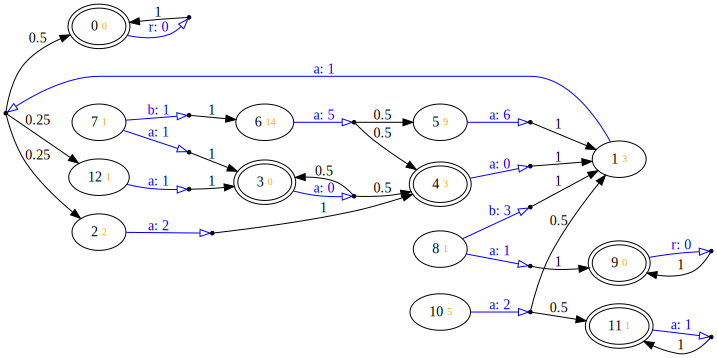

In [4]:
m.show("M")

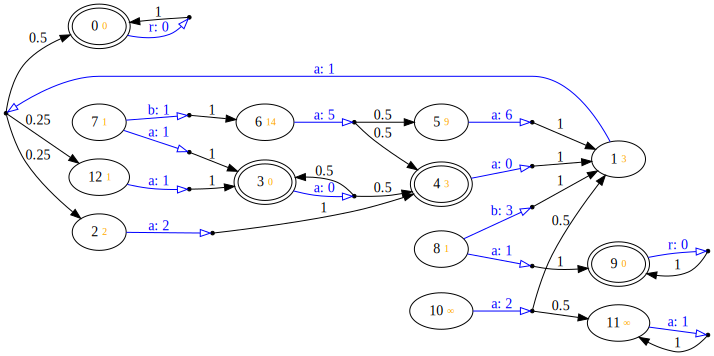

In [5]:
m.unset_reload(11)
m.show("M")

In [6]:
print(MI.get_values())
MI2 = minInitCons(m)
MI2.get_values()

[0, 3, 2, 0, 3, 9, 14, 1, 1, 0, 5, 1, 1]


[0, 3, 2, 0, 3, 9, 14, 1, 1, 0, inf, inf, 1]

## MinInitCons with capacity
We expect no change with capacity 14 as it is the highest minInitCons reached in the example. For `capacity=13`, however, there should be `∞` on state 6.

[0, 3, 2, 0, 3, 9, 14, 1, 1, 0, inf, inf, 1]


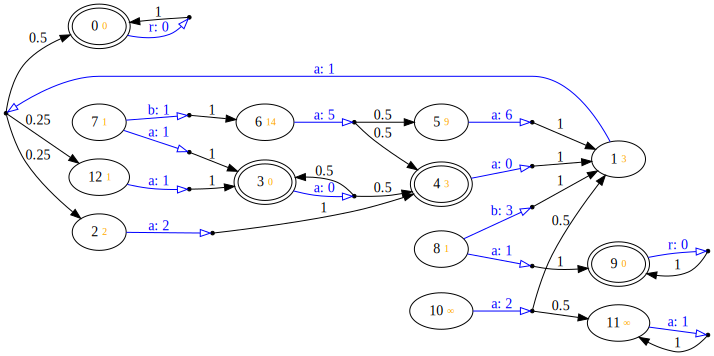

In [7]:
m.get_minInitCons(capacity=14)
print(m.minInitCons.values)
m

[0, 3, 2, 0, 3, 9, inf, 1, 1, 0, inf, inf, 1]


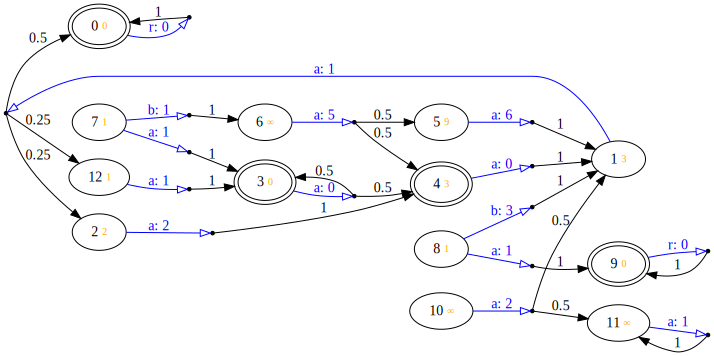

In [8]:
m.get_minInitCons(capacity=13)
print(m.minInitCons.values)
m

# SafeReloads
Safe reloads compute $\mathrm{minInitCons}$ such that only reload states $r$ with $\mathrm{minInitCons}(r) <= \mathsf{capacity}$ are considered as true reload states. Note that you should always specify `capacity` (either explicitly or when creating `minInitCons` object) as it makes no sense with `capacity = 0`. We visualize them with a red color. 

In [9]:
# Change the consumption on the action of st. 4
a = next(m.actions_for_state(3))
a.cons = 9

m.get_safeReloads(8)

[0, inf, inf, inf, inf, inf, inf, inf, 1, 0, inf, inf, inf]

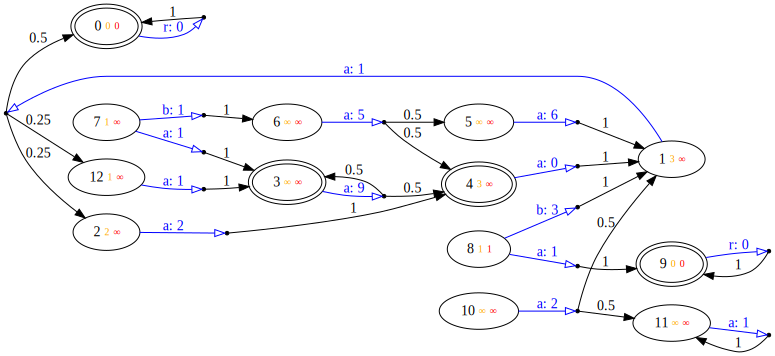

In [10]:
m.show("S")

## Example of incorrectness of the least fixpoint algorithm bounded by $|S|$ steps

In [11]:
from math import inf

class minInitCons_least:
    """Compute function minInitCons for given consMDP `m`.
    
    !!! This algorithm is incorect !!!
    
    minInitCons_m: S -> N ∪ {∞} returns for given `s` the minimum
    amount `s_m` of resource such that there exists a strategy that
    guarantees reachability of some reload state from s consuming
    at most `s_m`.
    
    Typical use:
    MI = minInitCons(mdp)
    MI.get_values()
    """

    def __init__(self, mdp):
        self.mdp     = mdp
        self.states  = mdp.num_states
        self.F       = [0] * self.states
        self.G       = [0] * self.states
        self.F_ready = False
        self.G_ready = False

    def action_F_value(self, a):
        non_reload_succs = [self.F[succ] for succ in a.distr.keys() 
                   if not self.mdp.is_reload(succ)]
        a_v = 0 if len(non_reload_succs) == 0 else max(non_reload_succs)
        return a_v + a.cons

    def fixpoint(self, func = "F"):
        """Computes the functional F (or G if requested).

        `func` can be either "F" or "G"

        !!! G should be always called after F !!!

        The functionals compute for each state `s` the maximum
        energy needed to reach a reload state from `s`.
        
        G detects increasing cycles by setting ∞ to states from
        which such cycle is reachable.
        """
        if func not in "FG":
            raise AttributeError(f'func has to be "F" or "G". {func} supplied')
        if func == "G" and not self.F_ready:
            raise AttributeError("G functional can be only called after F" +
                                 " is computed.")

        F = func == "F"

        values = self.F if F else self.G

        # iterate until a fixpoint is reached or for at most |S| steps
        iterate = True
        c = self.states      
        while iterate and c > 0:
            iterate = False
            c -= 1

            for s in range(self.states):
                current_v = values[s]
                actions = self.mdp.actions_for_state(s)
                # candidate_v is now the minimum over action values
                candidate_v = min([self.action_F_value(a) for a in actions])

                # F and G are monotonicly increasing, 
                # check for increase only
                if candidate_v > current_v:
                    values[s] = candidate_v if F else inf
                    iterate = True
        if F:
            self.F_ready = True
            # keep the F and G values separate
            self.G = list(values)
        else:
            self.G_ready = True

    def get_values(self, recompute=False):
        """Return (and compute) minInitCons list for self.m.
        
        When called for the first time, it computes the values.
        Recomputes the values if requested by `recompute`.
        """
        if recompute:
            self.F_ready, self.G_ready = False, False
            self.F = [0] * self.states
        if not self.F_ready:
            self.fixpoint("F")
        if not self.G_ready:
            self.fixpoint("G")
        return self.G


The following example uses two least fixpoint iterations bounded by $|S|$ and shows that it is actually incorrect. The needed bound is indeed $\mathrm{cons_{max}} \cdot |S|$ where $\mathrm{cons_{max}}$ is a maximum consumption of some action.

The result `0, inf, 6` is incorrect, the correct values are `0, 1000, 1001` as ilustrated on the figure below.

In [12]:
m = consMDP.ConsMDP()
m.new_state(True)
m.new_states(2)
m.add_action(0, {0:1}, "", 0)
m.add_action(1, {0:1}, "a", 1000)
m.add_action(1, {2:1}, "b", 1)
m.add_action(2, {1:1}, "b", 1)
MI = minInitCons_least(m)
MI.get_values()

[0, inf, 6]

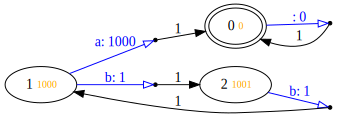

In [13]:
m.show("M")

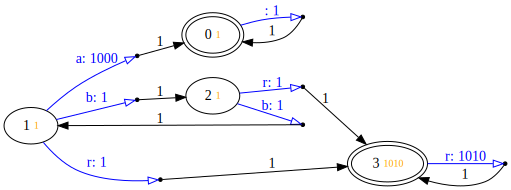

In [19]:
m = consMDP.ConsMDP()
m.new_state(True)
m.new_states(2)
m.new_state(True)
m.add_action(0, {0:1}, "", 1)
m.add_action(1, {0:1}, "a", 1000)
m.add_action(1, {2:1}, "b", 1)
m.add_action(2, {1:1}, "b", 1)
m.add_action(3, {3:1}, "r", 1010)
m.add_action(1, {3:1}, "r", 1)
m.add_action(2, {3:1}, "r", 1)
m.show("M")

In [23]:
from safety_bound_incorrect import minInitCons
MI = minInitCons(m, 1005)
MI.get_values()
MI.get_safe_values()

[1, 8, 9, inf]

The correct values are indicated in red at the figure below.

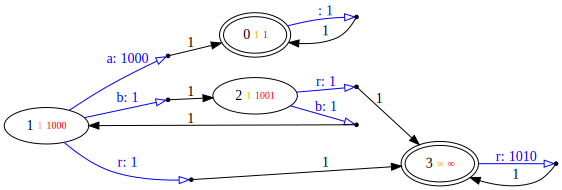

In [17]:
m.get_safeReloads(1005)
m

In [24]:
m.get_safeReloads(1005
                 )

[1, 1000, 1001, inf]